# Timeline analysis of sentiment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import numpy as np

In [3]:
src = '../data'

In [4]:
twitter_sentiment = pd.read_csv(join(src, 'twitter_sentiment_analysis.csv'), \
        usecols=['tweet_id', 'sentiment_polarity', 'sentiment_subjectivity'])
reddit_sentiment = pd.read_csv(join(src, 'reddit_sentiment_analysis.csv'), \
        usecols=['sentiment_polarity', 'sentiment_subjectivity', 'id'])

In [5]:
twitter_sentiment = twitter_sentiment.rename(columns={'tweet_id':'id'})
twitter_sentiment = twitter_sentiment.set_index('id')
reddit_sentiment = reddit_sentiment.set_index('id')

In [6]:
twitter = pd.read_csv(join(src, 'twitter_user_timelines_clean.csv'), parse_dates = ['created_at'])
reddit = pd.read_csv(join(src, 'reddit_user_comments.csv'))
reddit['created_at'] = pd.to_datetime(reddit['created_utc'], unit='s')

/home/jana/anaconda3/envs/misinfo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,3,10,12,16,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/jana/anaconda3/envs/misinfo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,3,5,6,8,9,11,12,13,18,20,22,23,25,28,29,34,36,37,38,41,42,43,45,49,50,51,52,54,55,57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
twitter = twitter.set_index('id')
reddit = reddit.set_index('id')

In [8]:
twitter = twitter.merge(twitter_sentiment, left_index=True, right_index=True)
reddit = reddit.merge(reddit_sentiment, left_index=True, right_index=True)

In [9]:
twitter_diagnosis_tweets = pd.read_csv(\
    join(src, 'twitter_user_diagnosis_dates.csv'), parse_dates=['created_at', 'created_at_date'])
twitter_diagnosis_tweets = twitter_diagnosis_tweets[\
                twitter_diagnosis_tweets['author.username'].isin(twitter['author.username'].unique())]
twitter_diagnosis_tweets = twitter_diagnosis_tweets.set_index('author.username')
# convert to naive timezone (we are only interested in days, so the few hours
# of error we can potentially make here are negligible)
twitter_diagnosis_tweets['created_at'] = twitter_diagnosis_tweets['created_at'].dt.tz_localize(None)


In [10]:
reddit_diagnosis_posts = pd.read_csv(join(src, 'reddit_user_diagnosis_dates.csv'),
                        parse_dates=['created_dt'])
reddit_diagnosis_posts = reddit_diagnosis_posts\
    .rename(columns={'created_dt':'created_at'})\
    .drop(columns=['created_utc'])
reddit_diagnosis_posts = reddit_diagnosis_posts.set_index('author')

# we only sample 175 random users from the reddit data
reddit = reddit[reddit['author'].isin(reddit_diagnosis_posts.index)]

In [11]:
def calculate_diagnosis_time_difference_twitter(row):
    username = row['author.username']
    tweet_datetime = row['created_at']
    diagnosis_datetime = twitter_diagnosis_tweets.loc[username]['created_at']
    datetime_diff =  tweet_datetime - diagnosis_datetime

    return datetime_diff

In [12]:
def calculate_diagnosis_time_difference_reddit(row):
    userID = row['author']
    post_datetime = row['created_at']
    diagnosis_datetime = reddit_diagnosis_posts.loc[userID]['created_at']
    datetime_diff =  post_datetime - diagnosis_datetime

    return datetime_diff

In [13]:
twitter['created_at'] = twitter['created_at'].dt.tz_localize(None)
twitter['timediff_to_diagnosis'] = twitter[['author.username', 'created_at']]\
    .apply(calculate_diagnosis_time_difference_twitter, axis=1)
twitter['timediff_to_diagnosis'] = twitter['timediff_to_diagnosis'].dt.days

In [14]:
reddit['timediff_to_diagnosis'] = reddit[['author', 'created_at']]\
    .apply(calculate_diagnosis_time_difference_reddit, axis=1)
reddit['timediff_to_diagnosis'] = reddit['timediff_to_diagnosis'].dt.days

## Polarity

In [15]:
twitter_polarity = twitter[['timediff_to_diagnosis', 'sentiment_polarity']]\
    .groupby(['timediff_to_diagnosis'])\
    .agg('mean')\
    .rename(columns={'sentiment_polarity':'mean_sentiment_polarity'})\
    .reset_index()

In [16]:
twitter_polarity.head()

,timediff_to_diagnosis,mean_sentiment_polarity
0,-4080,0.00
1,-4078,0.00
2,-4069,0.00
3,-4068,0.35
4,-4067,0.20


In [17]:
reddit_polarity = reddit[['timediff_to_diagnosis', 'sentiment_polarity']]\
    .groupby(['timediff_to_diagnosis'])\
    .agg('mean')\
    .rename(columns={'sentiment_polarity':'mean_sentiment_polarity'})\
    .reset_index()

In [18]:
reddit_polarity.head()

,timediff_to_diagnosis,mean_sentiment_polarity
0,-4124,-0.090774
1,-3921,0.663429
2,-3909,0.300000
3,-3897,-0.050000
4,-3896,-0.070370


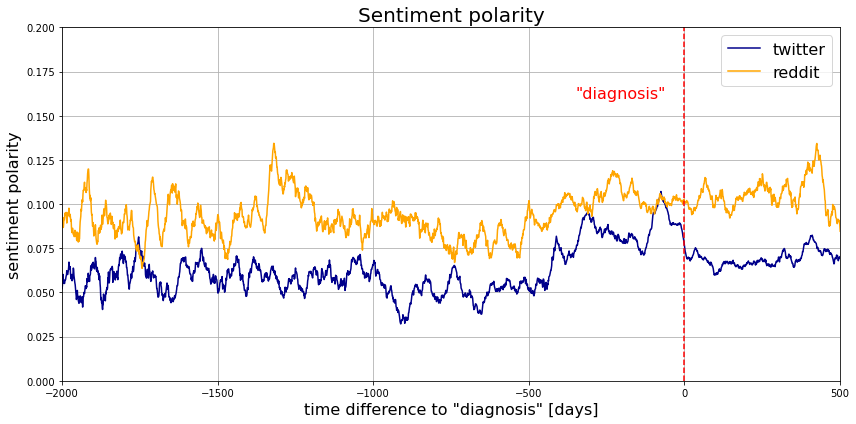

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

ymin = 0
ymax = 0.2

ax.plot(twitter_polarity['timediff_to_diagnosis'].rolling(30).mean(),\
        twitter_polarity['mean_sentiment_polarity'].rolling(30).mean(),
        label='twitter', color='DarkBlue')

ax.plot(reddit_polarity['timediff_to_diagnosis'].rolling(30).mean(),\
        reddit_polarity['mean_sentiment_polarity'].rolling(30).mean(),
        label='reddit', color='orange')

ax.plot([0, 0], [ymin, ymax], '--', color='r', )
ax.text(-350, ymax - ymax*0.2, '"diagnosis"', color='r', fontsize=16)
ax.set_xlabel('time difference to "diagnosis" [days]', fontsize=16)
ax.set_ylabel('sentiment polarity', fontsize=16)
ax.grid()
ax.set_xlim(-2000, 500)
ax.set_ylim(ymin, ymax)
ax.legend(fontsize=16)
ax.set_title('Sentiment polarity', fontsize=20)

fig.tight_layout()
plt.savefig('../plots/diagnosis_centered_sentiment_polarity.pdf')
plt.savefig('../plots/diagnosis_centered_sentiment_polarity.png', dpi=300)

## Subjectivity

In [20]:
twitter_subjectivity = twitter[['timediff_to_diagnosis', 'sentiment_subjectivity']]\
    .groupby(['timediff_to_diagnosis'])\
    .agg('mean')\
    .rename(columns={'sentiment_subjectivity':'mean_sentiment_subjectivity'})\
    .reset_index()

In [21]:
twitter_subjectivity.head()

,timediff_to_diagnosis,mean_sentiment_subjectivity
0,-4080,0.00
1,-4078,0.00
2,-4069,0.00
3,-4068,0.65
4,-4067,0.50


In [22]:
reddit_subjectivity = reddit[['timediff_to_diagnosis', 'sentiment_subjectivity']]\
    .groupby(['timediff_to_diagnosis'])\
    .agg('mean')\
    .rename(columns={'sentiment_subjectivity':'mean_sentiment_subjectivity'})\
    .reset_index()

In [23]:
reddit_subjectivity.head()

,timediff_to_diagnosis,mean_sentiment_subjectivity
0,-4124,0.278274
1,-3921,0.522286
2,-3909,0.729630
3,-3897,0.600000
4,-3896,0.751852


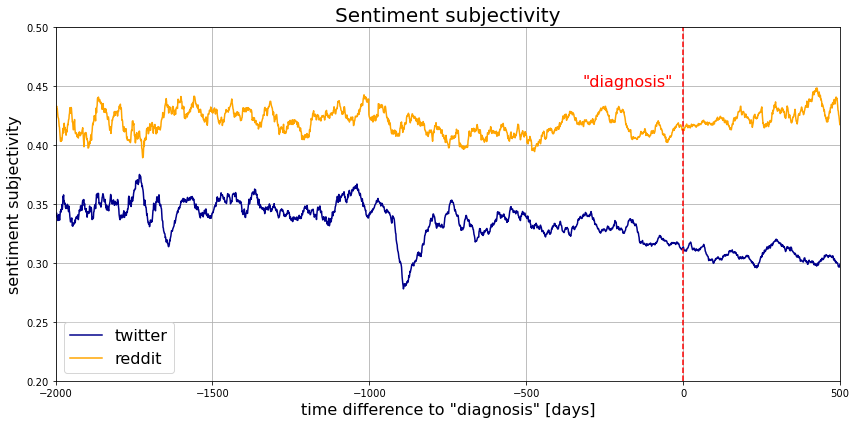

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

ymin = 0.2
ymax = 0.5

ax.plot(twitter_subjectivity['timediff_to_diagnosis'].rolling(30).mean(),\
        twitter_subjectivity['mean_sentiment_subjectivity'].rolling(30).mean(),
        label='twitter', color='DarkBlue')

ax.plot(reddit_subjectivity['timediff_to_diagnosis'].rolling(30).mean(),\
        reddit_subjectivity['mean_sentiment_subjectivity'].rolling(30).mean(),
        label='reddit', color='orange')

ax.plot([0, 0], [ymin, ymax], '--', color='r', )
ax.text(-320, ymax - ymax*0.1, '"diagnosis"', color='r', fontsize=16)
ax.set_xlabel('time difference to "diagnosis" [days]', fontsize=16)
ax.set_ylabel('sentiment subjectivity', fontsize=16)
ax.grid()
ax.set_xlim(-2000, 500)
ax.set_ylim(ymin, ymax)
ax.legend(fontsize=16, loc=3)
ax.set_title('Sentiment subjectivity', fontsize=20)

fig.tight_layout()
plt.savefig('../plots/diagnosis_centered_sentiment_subjectivity.pdf')
plt.savefig('../plots/diagnosis_centered_sentiment_subjectivity.png', dpi=300)

## Descriptive statistics

In [34]:
twitter = twitter.dropna(subset=['text'])

In [35]:
len(reddit)

298744

In [36]:
len(twitter)

1298624

In [37]:
len(reddit['author'].unique())

175

In [38]:
len(twitter['author.username'].unique())

103

In [39]:
reddit['text_length'] = reddit['body'].apply(lambda x: len(x))
twitter['text_length'] = twitter['text'].apply(lambda x: len(x))

In [41]:
twitter['text_length'].mean()

86.0051138743778

In [42]:
twitter['text_length'].std()

52.61091400906865

In [43]:
reddit['text_length'].mean()

204.40461733122675

In [44]:
reddit['text_length'].std()

395.8024214977647

In [47]:
twitter_timeline_length = twitter[['author.username', 'created_at']]\
    .groupby('author.username')\
    .agg(['min', 'max'])\
    .reset_index()

twitter_timeline_length['timeline_length'] = \
    (twitter_timeline_length['created_at']['max'] - \
    twitter_timeline_length['created_at']['min']).dt.days / 365

In [57]:
twitter_timeline_length['timeline_length'].mean()

8.040909695438224

In [58]:
twitter_timeline_length['timeline_length'].std()

3.511622378405742

In [59]:
reddit_timeline_length = reddit[['author', 'created_at']]\
    .groupby('author')\
    .agg(['min', 'max'])\
    .reset_index()

reddit_timeline_length['timeline_length'] = \
    (reddit_timeline_length['created_at']['max'] - \
    reddit_timeline_length['created_at']['min']).dt.days / 365

In [60]:
reddit_timeline_length['timeline_length'].mean()

3.449722113502935

In [61]:
reddit_timeline_length['timeline_length'].std()

3.054720580074654